In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


In [2]:
# Load the data from the CSV file
file_path = '/Users/yeshwanthsatyadev/Downloads/50_Startups.csv'  
df = pd.read_csv(file_path)

In [3]:
# Display the first few rows of the DataFrame & EDA
print(df.head())

   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


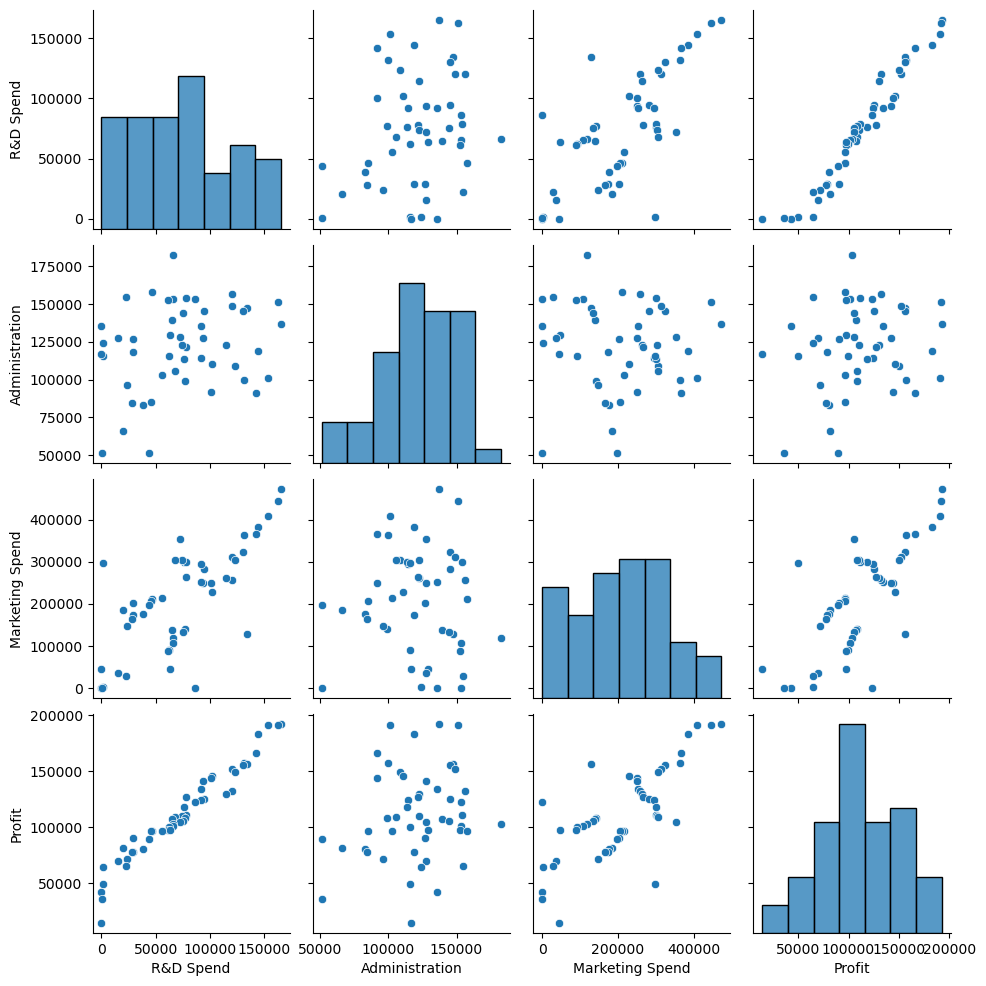

In [4]:
# Explore data and visualize relationships
sns.pairplot(df)
plt.show()

In [5]:
# Encode categorical variable 'State' using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['State'], drop_first=True)

In [6]:
# Split the data into features (X) and target variable (y)
X = df_encoded.drop("Profit", axis=1)
y = df_encoded["Profit"]

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Perform multiple linear regression
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [9]:
# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     140.1
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           1.13e-21
Time:                        02:29:43   Log-Likelihood:                -420.63
No. Observations:                  40   AIC:                             853.3
Df Residuals:                      34   BIC:                             863.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.403e+04   8457.293     

In [10]:
# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF:")
print(vif_data)


VIF:
          Variable       VIF
0        R&D Spend  8.451019
1   Administration  4.950277
2  Marketing Spend  8.092278
3    State_Florida  2.004519
4   State_New York  1.928836


In [11]:
# Residual analysis
y_pred = model.predict(sm.add_constant(X_test))
residuals = y_test - y_pred

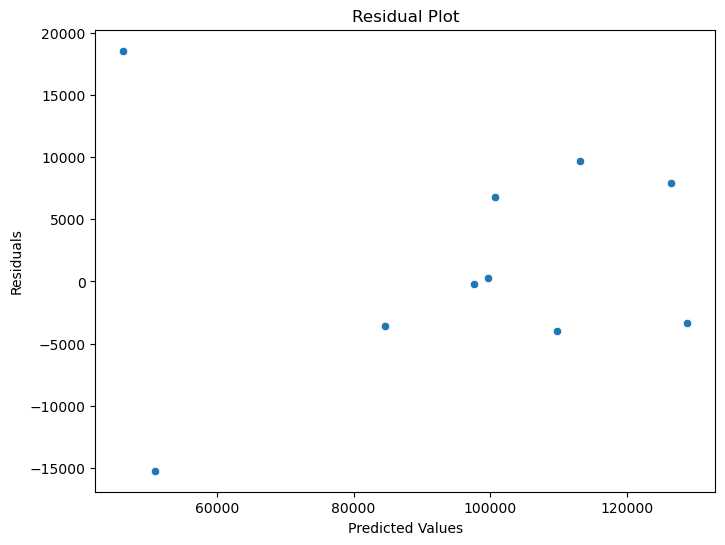

In [12]:
# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


/var/folders/2f/6715vcj17512v437zpm1fm440000gn/T/ipykernel_58406/878186881.py:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)


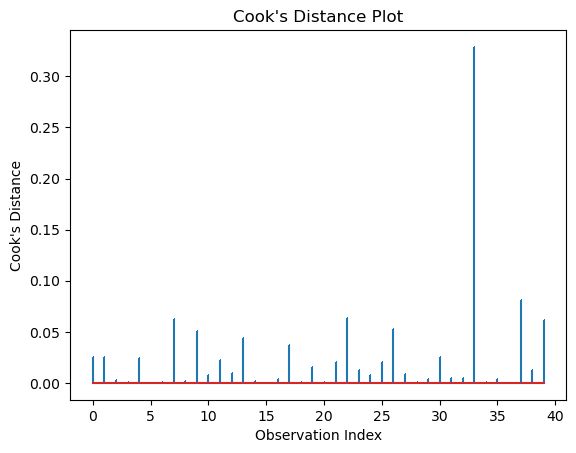

In [13]:
# Cook's distance
influence = model.get_influence()
(c, _) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
plt.title("Cook's Distance Plot")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()

In [17]:
# Leverage vs Residuals squared
plt.figure(figsize=(8, 6))

# Get leverage values
leverage = model.get_influence().hat_matrix_diag

# Make sure residuals and leverage have the same shape
if len(residuals) == len(leverage):
    plt.scatter(leverage, residuals**2, alpha=0.5)
    plt.title('Leverage vs Residuals Squared')
    plt.xlabel('Leverage')
    plt.ylabel('Residuals Squared')

    # Add a horizontal line at y=1 (typical threshold for influential points)
    plt.axhline(y=1, color='red', linestyle='--', label='Threshold')

    plt.legend()
    plt.show()
else:
    print("Error: Dimensions of residuals and leverage are not the same.")


Error: Dimensions of residuals and leverage are not the same.


<Figure size 800x600 with 0 Axes>

In [18]:
# Model deletion diagnostics (remove influential points)
influential_points = np.where(c > 4 / len(X))
X_train_no_influential = X_train.drop(index=influential_points[0])
y_train_no_influential = y_train.drop(index=influential_points[0])

In [19]:
# Fit the model without influential points
model_no_influential = sm.OLS(y_train_no_influential, sm.add_constant(X_train_no_influential)).fit()

In [20]:
# Model summary without influential points
print(model_no_influential.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     130.2
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           2.73e-20
Time:                        02:34:17   Log-Likelihood:                -400.51
No. Observations:                  38   AIC:                             813.0
Df Residuals:                      32   BIC:                             822.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.531e+04   9818.928     

In [21]:
# Calculate R-squared for the final model
y_pred_final = model_no_influential.predict(sm.add_constant(X_test))
r2_final = r2_score(y_test, y_pred_final)
print(f"\nR-squared for the final model: {r2_final:.4f}")


R-squared for the final model: 0.8961
